In [16]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib
matplotlib.use('Agg')
%matplotlib inline

import matplotlib.pyplot as plt

import torch
import torch.nn as nn 
from torch.autograd import Variable
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error



/home/eason/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [18]:
from pandas import DataFrame
from pandas import concat
from pandas import read_csv

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
#df = DataFrame()
#df['t'] = [x for x in range(10)]
#df['y']=df['t'].shift(-1)
#print(df)
pathProg = 'C:\\Users\\林亦盛\\Downloads\\UtilizationDataLog'

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
dataset = read_csv('datanew300.csv',header=0)
values = dataset.values

# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(values, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head()) 
''' 

data = series_to_supervised(values)
print(data)
print(values[:,4])
'''

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1       -1.0       -1.0        2.0        0.0        1.0       -2.0   
2       -1.0       -1.0        0.0        0.0        1.0        0.0   
3       -1.0       -2.0        0.0        0.0        1.0       -2.0   
4       -2.0       -2.0        0.0        0.0        1.0        0.0   
5       -2.0       -2.0        0.0        0.0        1.0        0.0   

   var7(t-1)  var1(t)  
1       -1.0     -1.0  
2        0.0     -1.0  
3        0.0     -2.0  
4        0.0     -2.0  
5        0.0      0.0  


' \n\ndata = series_to_supervised(values)\nprint(data)\nprint(values[:,4])\n'

In [19]:
import math
import numpy as np
import torch
data = reframed.values

n_split = int(0.3 * len(data))
print(n_split)

train_X = Variable(torch.from_numpy(data[n_split:, :-1]), requires_grad=False)
train_y = Variable(torch.from_numpy(data[n_split:, 1:]), requires_grad=False)
test_X = Variable(torch.from_numpy(data[:n_split, :-1]), requires_grad=False)
test_y = Variable(torch.from_numpy(data[:n_split, 1:]), requires_grad=False)

print(train_X.size(), train_y.size(), test_X.size(), test_y.size())

156
torch.Size([366, 7]) torch.Size([366, 7]) torch.Size([156, 7]) torch.Size([156, 7])


In [20]:
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(1, 51)
        self.lstm2 = nn.LSTMCell(51, 1)

    def forward(self, input, future=0):
        outputs = []
        h_t = Variable(
            torch.zeros(input.size(0), 51), requires_grad=False)
        c_t = Variable(
            torch.zeros(input.size(0), 51), requires_grad=False)
        h_t2 = Variable(
            torch.zeros(input.size(0), 1), requires_grad=False)
        c_t2 = Variable(
            torch.zeros(input.size(0), 1), requires_grad=False)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(c_t, (h_t2, c_t2))
            outputs += [c_t2]

        for i in range(future):  # if we should predict the future
            h_t, c_t = self.lstm1(c_t2, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(c_t, (h_t2, c_t2))
            outputs += [c_t2]

        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [25]:
# build the model
seq = Sequence()
# seq.double()
criterion = nn.MSELoss()

# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.Adam(seq.parameters())

loss_list = []
test_loss_list = []

epoch_num = 100

# begin to train
for epoch in range(epoch_num):
    print('epoch : ', epoch)

    def closure():
        optimizer.zero_grad()
        out = seq(train_X)
        loss = criterion(out, train_y)
#         print('loss:', loss.data.numpy()[0])
        loss_list.append(loss.data.numpy()[0])
        loss.backward()
        return loss

    optimizer.step(closure)

#   # begin to predict
#     future = 1000
#     pred = seq(test_X, future=future)
    pred = seq(test_X)
    loss = criterion(pred, test_y)
#     print('test loss:', loss.data.numpy()[0])
    test_loss_list.append(loss.data.numpy()[0])

    y = pred.data.numpy()

epoch :  0
epoch :  1
epoch :  2
epoch :  3
epoch :  4
epoch :  5
epoch :  6
epoch :  7
epoch :  8
epoch :  9
epoch :  10
epoch :  11
epoch :  12
epoch :  13
epoch :  14
epoch :  15
epoch :  16
epoch :  17
epoch :  18
epoch :  19
epoch :  20
epoch :  21
epoch :  22
epoch :  23
epoch :  24
epoch :  25
epoch :  26
epoch :  27
epoch :  28
epoch :  29
epoch :  30
epoch :  31
epoch :  32
epoch :  33
epoch :  34
epoch :  35
epoch :  36
epoch :  37
epoch :  38
epoch :  39
epoch :  40
epoch :  41
epoch :  42
epoch :  43
epoch :  44
epoch :  45
epoch :  46
epoch :  47
epoch :  48
epoch :  49
epoch :  50
epoch :  51
epoch :  52
epoch :  53
epoch :  54
epoch :  55
epoch :  56
epoch :  57
epoch :  58
epoch :  59
epoch :  60
epoch :  61
epoch :  62
epoch :  63
epoch :  64
epoch :  65
epoch :  66
epoch :  67
epoch :  68
epoch :  69
epoch :  70
epoch :  71
epoch :  72
epoch :  73
epoch :  74
epoch :  75
epoch :  76
epoch :  77
epoch :  78
epoch :  79
epoch :  80
epoch :  81
epoch :  82
epoch :  83
ep

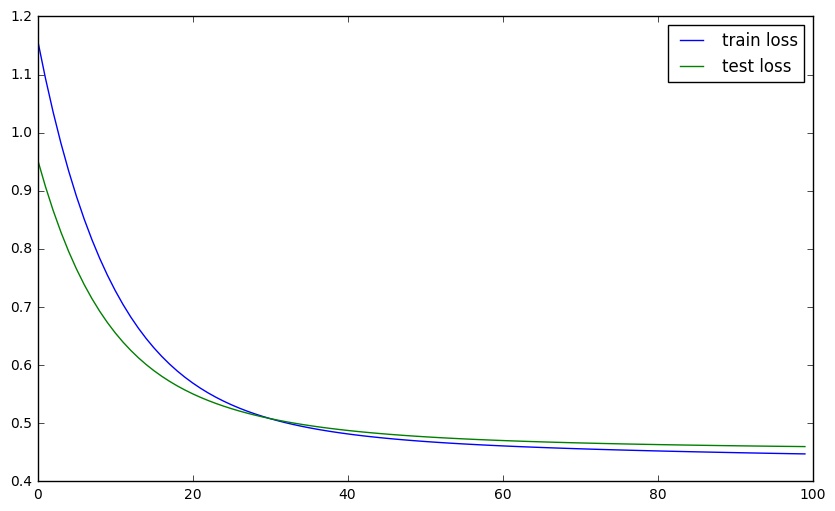

In [26]:
plt.figure(figsize=(10,6))
plt.plot(range(epoch_num), loss_list, label='train loss')
plt.plot(range(epoch_num), test_loss_list, label='test loss')
plt.legend()
plt.savefig('100 split300 new.png', dpi=200)

